In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

2025-05-30 19:35:54.582272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748633754.776671      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748633754.837088      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define constants
LABEL_NUM = 2
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load dataset
data_files = {"train": "train/train.csv", "test": "test/test.csv"}
dataset = load_dataset(path="/kaggle/input/review-dataset", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=LABEL_NUM)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Define encoder
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=SEQ_LEN)

In [6]:
# Data tokenization
training_set = dataset['train'].map(tokenize_function, batched=True)
testing_set = dataset['test'].map(tokenize_function, batched=True)

# Format torch
training_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
testing_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/30256 [00:00<?, ? examples/s]

Map:   0%|          | 0/7576 [00:00<?, ? examples/s]

In [7]:
# Training stage

# Load GPU if had
model.to(device)

# Load data by DataLoader
train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
# Load optimizer
optimizer = torch.optim.RAdam(model.parameters(), lr=LR)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

100%|██████████| 1891/1891 [13:17<00:00,  2.37it/s]


Epoch 1, Loss: 0.34060306331937684


100%|██████████| 1891/1891 [13:19<00:00,  2.37it/s]


Epoch 2, Loss: 0.23875241601245703


100%|██████████| 1891/1891 [13:19<00:00,  2.36it/s]


Epoch 3, Loss: 0.20032324718280894


100%|██████████| 1891/1891 [13:19<00:00,  2.36it/s]


Epoch 4, Loss: 0.16527150463340445


100%|██████████| 1891/1891 [13:19<00:00,  2.36it/s]

Epoch 5, Loss: 0.13599211484314958


In [8]:
# Testing stage 
test_dataloader = DataLoader(testing_set, batch_size=16)

predictions = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

100%|██████████| 474/474 [00:52<00:00,  9.06it/s]


In [9]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(true_labels, predictions, digits=3))
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions))
print("Recall:", recall_score(true_labels, predictions))
print("F1-Score:", f1_score(true_labels, predictions))

              precision    recall  f1-score   support

           0      0.919     0.909     0.914      3748
           1      0.912     0.921     0.916      3828

    accuracy                          0.915      7576
   macro avg      0.915     0.915     0.915      7576
weighted avg      0.915     0.915     0.915      7576

Accuracy: 0.9151267159450898
Precision: 0.9116050659085035
Recall: 0.9213688610240335
F1-Score: 0.9164609588151228


In [10]:
from sklearn.metrics import confusion_matrix

# y_true: true labels
# y_pred: predicted labels
cm = confusion_matrix(true_labels, predictions)
cm

array([[3406,  342],
       [ 301, 3527]])

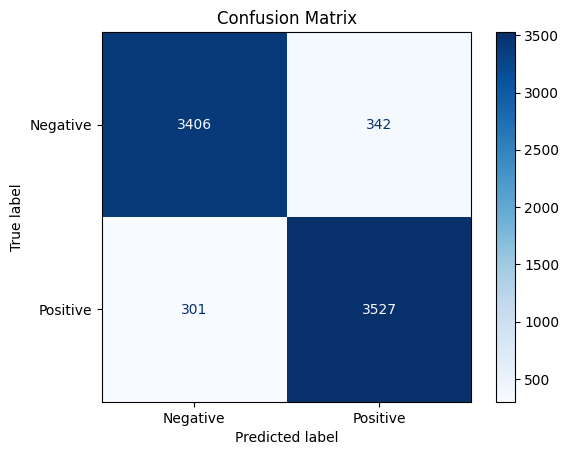

In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()